In [81]:
!pip install pyvista
!pip install open3d

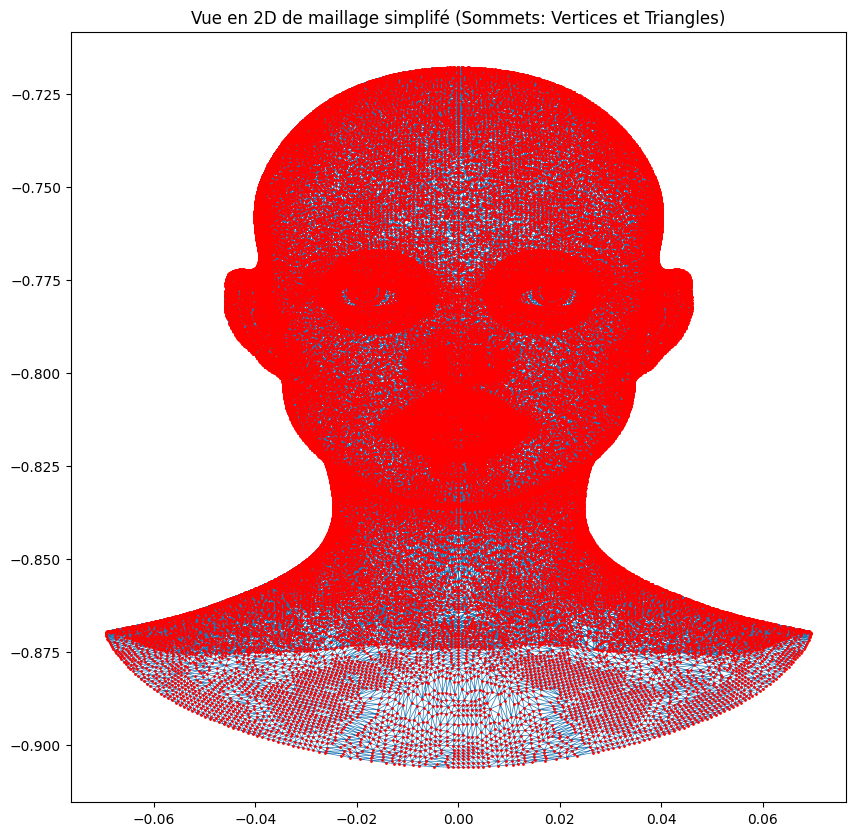

In [82]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Load the mesh
mesh = o3d.io.read_triangle_mesh("/content/BustBaseMesh_Decimated.obj")

# Convert mesh vertices to NumPy array
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)

# Plot the vertices in 2D
plt.figure(figsize=(10, 10))
plt.triplot(vertices[:, 0], vertices[:, 1], triangles, linewidth=0.5)
plt.scatter(vertices[:, 0], vertices[:, 1], color='red', s=1)
plt.title('Vue en 2D de maillage simplifé (Sommets: Vertices et Triangles)')
plt.show()


Nombre de faces avant simplification : 149178
Nombre de faces après simplification : 500


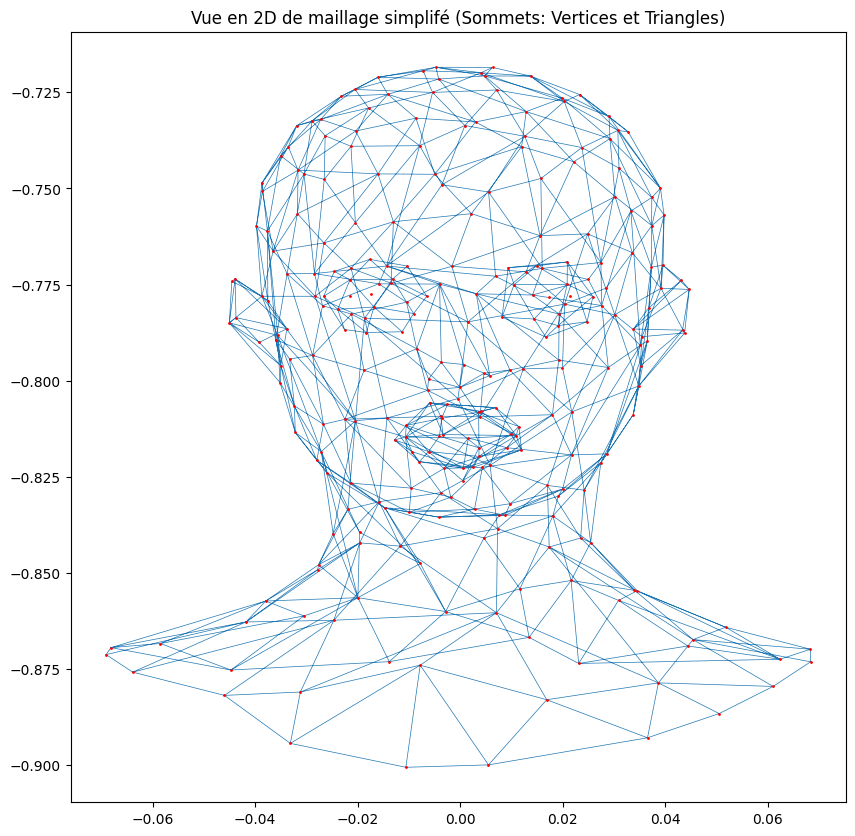

In [83]:
# Paramètres de simplification : nombre cible de faces
nombre_faces_cible = 500

# Utilisation de l’algorithme de simplification quadratique
mesh_simplifiee = mesh.simplify_quadric_decimation(target_number_of_triangles=nombre_faces_cible)

# Affichage des statistiques de la nouvelle mesh
print("Nombre de faces avant simplification :", np.asarray(mesh.triangles).shape[0])
print("Nombre de faces après simplification :", np.asarray(mesh_simplifiee.triangles).shape[0])

# Convert mesh vertices to NumPy array
vertices = np.asarray(mesh_simplifiee.vertices)
triangles = np.asarray(mesh_simplifiee.triangles)

# Plot the vertices in 2D
plt.figure(figsize=(10, 10))
plt.triplot(vertices[:, 0], vertices[:, 1], triangles, linewidth=0.5)
plt.scatter(vertices[:, 0], vertices[:, 1], color='red', s=1)
plt.title('Vue en 2D de maillage simplifé (Sommets: Vertices et Triangles)')
plt.show()



---

# **Simplification de la Mesh originale  149178 points ---> 500 points**

---



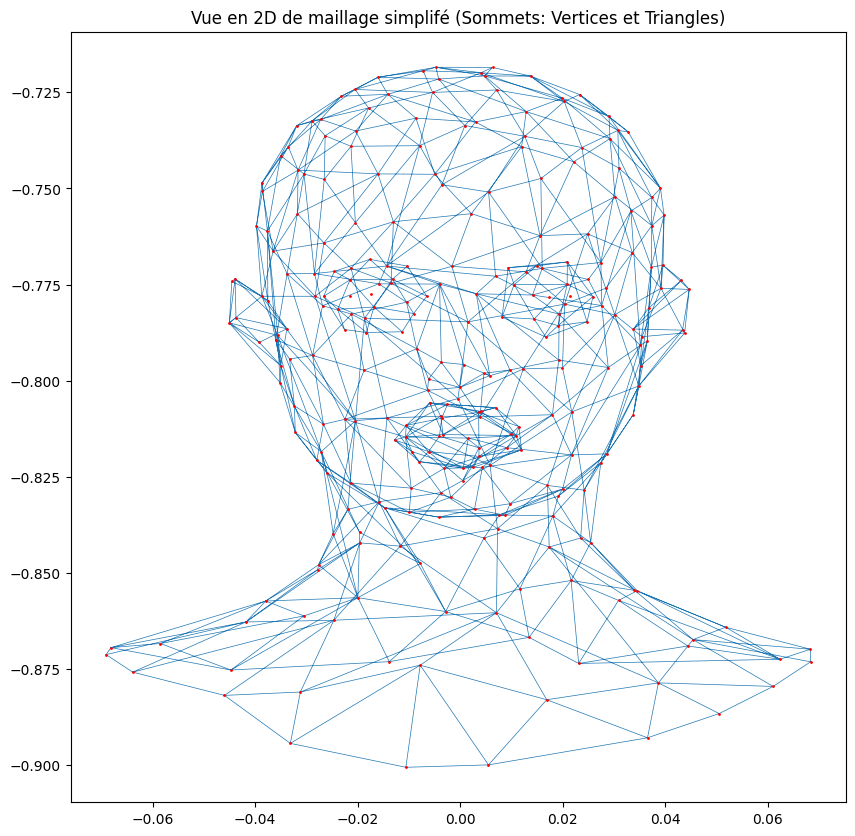

In [84]:
import numpy as np
import open3d as o3d

# Step 1: Initialize Quadrics for each vertex in the mesh
def initialize_quadrics(vertices, faces):
    quadrics = [np.zeros((4, 4)) for _ in vertices]

    # Iterate through each face to compute the plane equation and update vertex quadrics
    for face in faces:
        # Get vertex positions
        v1, v2, v3 = vertices[face[0]], vertices[face[1]], vertices[face[2]]

        # Compute the normal vector of the face
        normal = np.cross(v2 - v1, v3 - v1)
        normal = normal / np.linalg.norm(normal)  # Normalize the normal vector

        # Plane equation parameters: ax + by + cz + d = 0
        a, b, c = normal
        d = -np.dot(normal, v1)

        # Construct the plane equation matrix Kp
        plane_quadric = np.array([
            [a * a, a * b, a * c, a * d],
            [a * b, b * b, b * c, b * d],
            [a * c, b * c, c * c, c * d],
            [a * d, b * d, c * d, d * d]
        ])

        # Add this plane quadric to each vertex of the face
        for vertex_index in face:
            quadrics[vertex_index] += plane_quadric

    return quadrics


def decimate_mesh(vertices, faces, target_vertex_count):
    # Convert to an Open3D mesh for decimation
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)

    # Perform mesh simplification
    mesh_simplified = mesh.simplify_quadric_decimation(target_vertex_count)

    return np.asarray(mesh_simplified.vertices), np.asarray(mesh_simplified.triangles)


# Load your mesh
mesh_path = 'BustBaseMesh_Decimated.obj'  # Adjust the path accordingly
mesh = o3d.io.read_triangle_mesh(mesh_path)

# Convert mesh vertices and faces to numpy arrays
vertices = np.asarray(mesh.vertices)
faces = np.asarray(mesh.triangles)

# Initialize quadrics for the mesh
quadrics = initialize_quadrics(vertices, faces)

# Decimate the mesh to approximately 500 vertices
target_vertex_count = 500
decimated_vertices, decimated_faces = decimate_mesh(vertices, faces, target_vertex_count)


# nos nouveaux vertices, triangle
vertices = decimated_vertices
triangles = decimated_faces

# Plot the vertices in 2D
plt.figure(figsize=(10, 10))
plt.triplot(vertices[:, 0], vertices[:, 1], triangles, linewidth=0.5)
plt.scatter(vertices[:, 0], vertices[:, 1], color='red', s=1)
plt.title('Vue en 2D de maillage simplifé (Sommets: Vertices et Triangles)')
plt.show()



---

# Un chemin géodésiques entre deux points (vertices) de la maille pris au hasard

---



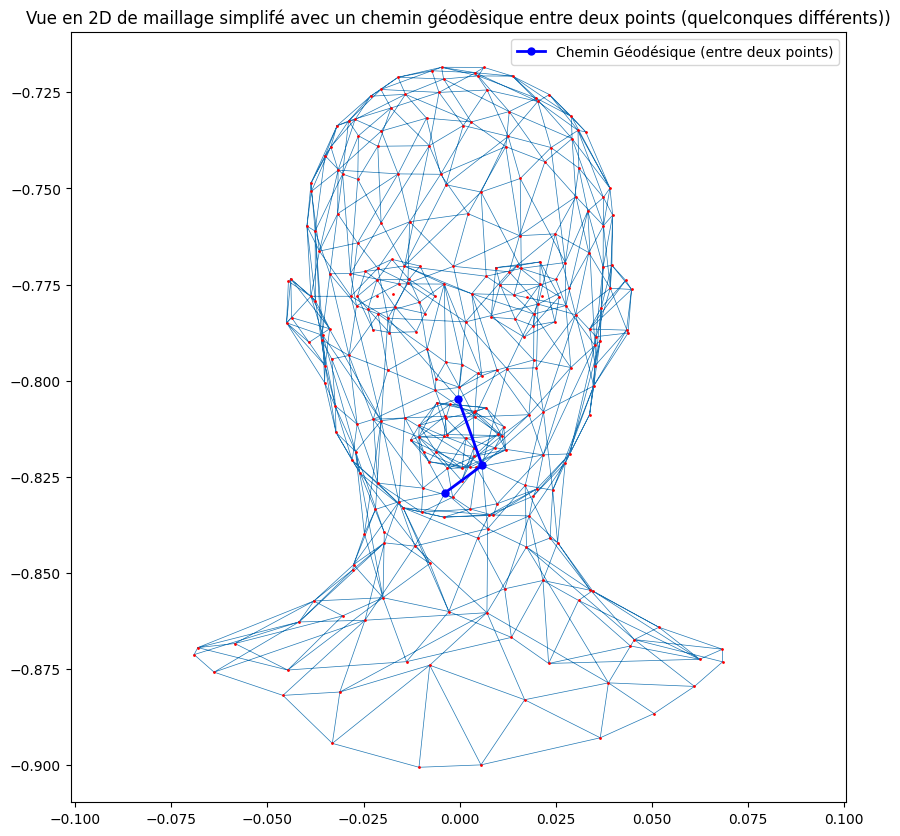

In [85]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import random
import networkx as nx



# Function to find the geodesic path using Dijkstra's algorithm
def find_geodesic_path(vertices, triangles, start_index, end_index):
    # Create a graph from the mesh
    graph = nx.Graph()

    # Add edges to the graph based on the triangles
    for triangle in triangles:
        p1, p2, p3 = triangle
        edges = [(p1, p2), (p2, p3), (p3, p1)]
        for edge in edges:
            dist = np.linalg.norm(vertices[edge[0]] - vertices[edge[1]])
            graph.add_edge(edge[0], edge[1], weight=dist)

    # Calculate the shortest path using Dijkstra's algorithm
    path = nx.dijkstra_path(graph, start_index, end_index)
    return path


# Select two random vertices to find the geodesic path between
start_index = random.choice(range(len(vertices)))
end_index = random.choice(range(len(vertices)))

# Ensure the start and end are different
while start_index == end_index:
    end_index = random.choice(range(len(vertices)))

# Find the geodesic path
path = find_geodesic_path(vertices, triangles, start_index, end_index)

# Plot the mesh and the geodesic path
plt.figure(figsize=(10, 10))
plt.triplot(vertices[:, 0], vertices[:, 1], triangles, linewidth=0.5)
plt.scatter(vertices[:, 0], vertices[:, 1], color='red', s=1)

# Plot the geodesic path
path_vertices = vertices[path]
plt.plot(path_vertices[:, 0], path_vertices[:, 1], color='blue', linewidth=2, marker='o', markersize=5, label='Chemin Géodésique (entre deux points)')
plt.title('Vue en 2D de maillage simplifé avec un chemin géodèsique entre deux points (quelconques différents))')
plt.legend()
plt.axis('equal')  # Equal scaling for x and y axes
plt.show()



---

# **Calcul + Visualisation des descripteurs HOG avec un Histogramme 3D:**

---



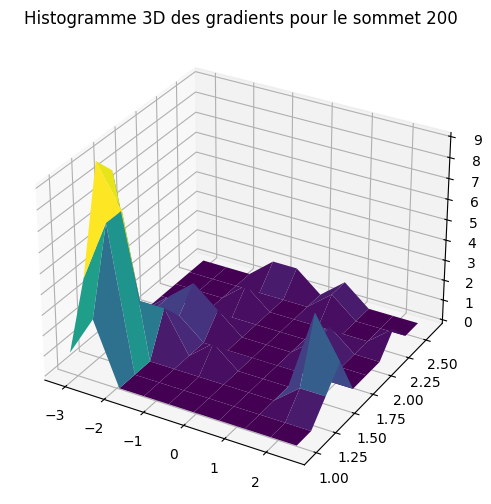

Les descripteurs HOG pour chaque sommet sont calculés.


In [88]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Définir un rayon de support pour calculer les gradients locaux autour de chaque sommet
support_radius = 0.05  # rayon en unités de distance, ajustable pour des détails plus fins

def calculate_curvature(vertices, triangles):
    """Calculer la courbure locale pour chaque sommet en utilisant le rayon de support défini."""
    curvatures = np.zeros(len(vertices))

    for i, vertex in enumerate(vertices):
        # Trouver les sommets voisins dans le rayon de support
        distances = np.linalg.norm(vertices - vertex, axis=1)
        neighborhood = vertices[distances < support_radius]

        # Calculer les vecteurs de gradient pour chaque voisin
        gradients = neighborhood - vertex
        curvatures[i] = np.linalg.norm(np.mean(gradients, axis=0))  # Norme de la moyenne des gradients

    return curvatures

# Calculer la courbure locale pour le maillage simplifié
curvatures = calculate_curvature(vertices, triangles)

# Fonction pour calculer les HOG pour un sommet spécifique
def calculate_hog_for_vertex(vertices, vertex_index, radius=0.05, bins=10):
    """Calculer un histogramme des gradients pour un sommet donné."""
    vertex = vertices[vertex_index]
    distances = np.linalg.norm(vertices - vertex, axis=1)
    neighborhood = vertices[distances < radius]

    # Calculer les gradients
    gradients = neighborhood - vertex

    # Convertir les gradients en angles (theta, phi) pour les binner
    theta = np.arctan2(gradients[:, 1], gradients[:, 0])
    phi = np.arccos(gradients[:, 2] / (np.linalg.norm(gradients, axis=1) + 1e-6))

    # Calculer l'histogramme 3D
    hist, edges = np.histogramdd((theta, phi), bins=bins)

    return hist, edges

# Exemple: Calculer un histogramme des gradients pour un sommet aléatoire ou choisi
vertex_index = 200  # Choisir un sommet avec un maximum de courbure
histogram, edges = calculate_hog_for_vertex(vertices, vertex_index)

# Afficher l'histogramme 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(edges[0][:-1], edges[1][:-1])
ax.plot_surface(x, y, histogram.T, cmap='viridis')
ax.set_title(f'Histogramme 3D des gradients pour le sommet {vertex_index}')
plt.show()

# Application de HOG à chaque sommet pour la description du visage
face_descriptors = [calculate_hog_for_vertex(vertices, i)[0] for i in range(len(vertices))]

print("Les descripteurs HOG pour chaque sommet sont calculés.")




---
# TESTS du robustesse de ces Invariants/Descripteurs HOG :



---



In [89]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def rotate_mesh(vertices, angle, axis='z'):
    """
    Rotate the mesh vertices around a specified axis by a given angle.

    Parameters:
        vertices (np.ndarray): Array of shape (N, 3) for N vertices.
        angle (float): Rotation angle in degrees.
        axis (str): Axis to rotate around ('x', 'y', 'z').

    Returns:
        np.ndarray: Rotated vertices.
    """
    # Create the rotation object
    if axis == 'x':
        rotation = R.from_euler('x', angle, degrees=True)
    elif axis == 'y':
        rotation = R.from_euler('y', angle, degrees=True)
    elif axis == 'z':
        rotation = R.from_euler('z', angle, degrees=True)
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'.")

    # Rotate each vertex
    rotated_vertices = rotation.apply(vertices)
    return rotated_vertices


In [90]:
def compare_descriptors(baseline_descriptors, rotated_descriptors):
    """
    Compare the baseline and rotated descriptors using cosine similarity and Euclidean distance.

    Parameters:
        baseline_descriptors (np.ndarray): Original descriptors, shape (N, M).
        rotated_descriptors (np.ndarray): Rotated descriptors, shape (N, M).

    Returns:
        (np.ndarray, np.ndarray): Arrays of cosine similarities and Euclidean distances for each vertex.
    """
    # Cosine Similarity
    dot_product = np.sum(baseline_descriptors * rotated_descriptors, axis=1)
    baseline_norm = np.linalg.norm(baseline_descriptors, axis=1)
    rotated_norm = np.linalg.norm(rotated_descriptors, axis=1)
    cosine_similarity = dot_product / (baseline_norm * rotated_norm)

    # Euclidean Distance
    euclidean_distance = np.linalg.norm(baseline_descriptors - rotated_descriptors, axis=1)

    return cosine_similarity, euclidean_distance


In [91]:
import numpy as np
import open3d as o3d

def calculate_hog_descriptors(vertices, faces, radius=0.1, num_bins=8):
    """
    Calculate HOG descriptors for each vertex on a 3D mesh.

    Parameters:
    vertices (np.ndarray): Array of vertices in the mesh.
    faces (np.ndarray): Array of triangular faces in the mesh.
    radius (float): Radius to define the neighborhood around each vertex.
    num_bins (int): Number of bins for the gradient histogram.

    Returns:
    np.ndarray: HOG descriptors for each vertex.
    """
    # Initialize an array to store the descriptors for each vertex
    descriptors = np.zeros((len(vertices), num_bins))

    # Convert vertices to an Open3D PointCloud for efficient neighborhood search
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(vertices)
    kdtree = o3d.geometry.KDTreeFlann(pcd)

    # Loop over each vertex to calculate its HOG descriptor
    for i, vertex in enumerate(vertices):
        # Find neighboring vertices within the specified radius
        [_, idx, _] = kdtree.search_radius_vector_3d(vertex, radius)
        neighbors = vertices[idx]

        # Calculate the gradient directions between the vertex and its neighbors
        gradients = neighbors - vertex
        gradient_magnitudes = np.linalg.norm(gradients, axis=1)

        # Avoid division by zero by only keeping non-zero gradients
        nonzero_gradients = gradients[gradient_magnitudes > 0]
        gradient_magnitudes = gradient_magnitudes[gradient_magnitudes > 0]

        # Calculate angles in the local reference frame for binning
        gradient_angles = np.arctan2(nonzero_gradients[:, 1], nonzero_gradients[:, 0])

        # Create the histogram of gradient directions
        histogram, _ = np.histogram(gradient_angles, bins=num_bins, range=(-np.pi, np.pi), weights=gradient_magnitudes)
        descriptors[i] = histogram

    # Normalize each descriptor to have unit norm
    descriptors = np.array([desc / np.linalg.norm(desc) if np.linalg.norm(desc) > 0 else desc for desc in descriptors])

    return descriptors

# Example usage to get baseline descriptors
baseline_descriptors = calculate_hog_descriptors(decimated_vertices, decimated_faces)

print(baseline_descriptors, baseline_descriptors.shape)

[[0.33063828 0.66393535 0.40577359 ... 0.21910673 0.3350003  0.20968639]
 [0.23350714 0.47417496 0.36248459 ... 0.35166432 0.42304908 0.41446425]
 [0.12097824 0.40072262 0.56241704 ... 0.33262989 0.40193527 0.29561638]
 ...
 [0.14355217 0.03120786 0.06035649 ... 0.66382974 0.69936779 0.13834896]
 [0.32941545 0.59101037 0.57417043 ... 0.15325998 0.18020902 0.19359707]
 [0.375064   0.66805587 0.21653993 ... 0.1876899  0.40009507 0.38199631]] (275, 8)


In [92]:
angles = np.arange(0, 91, 15)  # Rotation de 0° à 90° en incréments de 15°
baseline_descriptors = calculate_hog_descriptors(decimated_vertices, decimated_faces)  # Descripteurs originaux

cosine_similarities = []
euclidean_distances = []

for angle in angles:
    rotated_vertices = rotate_mesh(decimated_vertices, angle, axis='z')
    rotated_descriptors = calculate_hog_descriptors(rotated_vertices, decimated_faces)
    cosine_sim, euclidean_dist = compare_descriptors(baseline_descriptors, rotated_descriptors)
    cosine_similarities.append(cosine_sim)
    euclidean_distances.append(euclidean_dist)


In [93]:
curvature_threshold = 0.1  # Seuil de courbure pour sélectionner des points avec haute courbure
high_curvature_points = np.where(curvatures > curvature_threshold)[0]


Descripteurs pour l'angle 0 ont la forme: ()


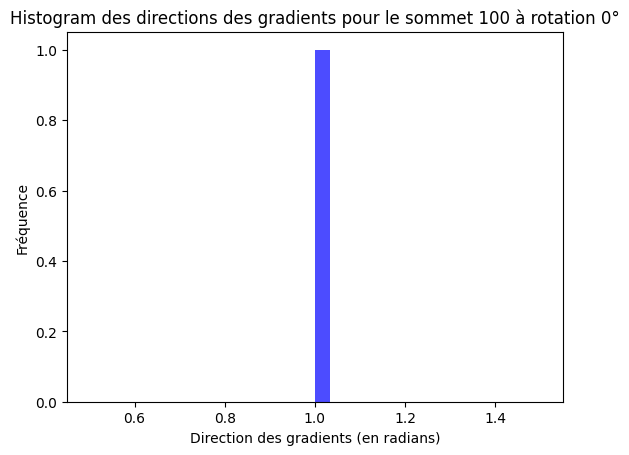

Descripteurs pour l'angle 15 ont la forme: ()


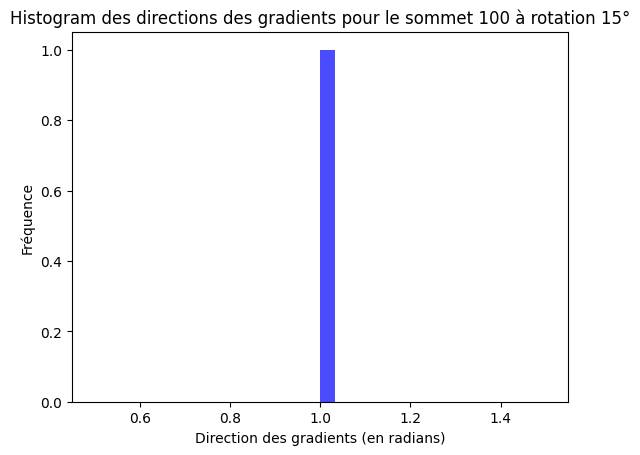

Descripteurs pour l'angle 30 ont la forme: ()


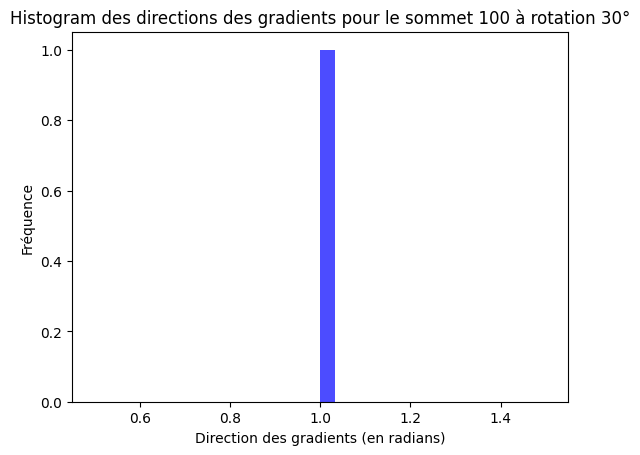

Descripteurs pour l'angle 45 ont la forme: ()


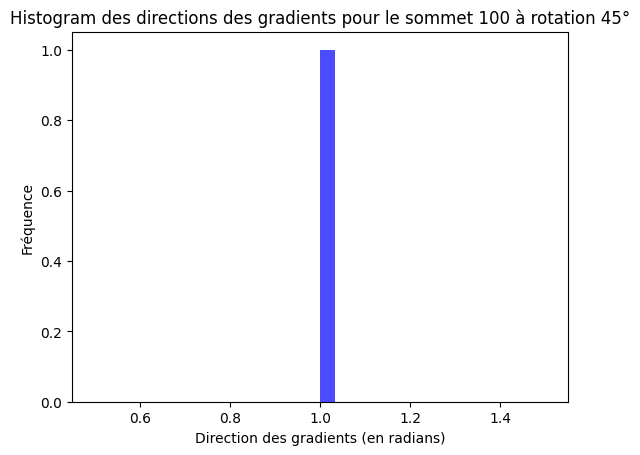

Descripteurs pour l'angle 60 ont la forme: ()


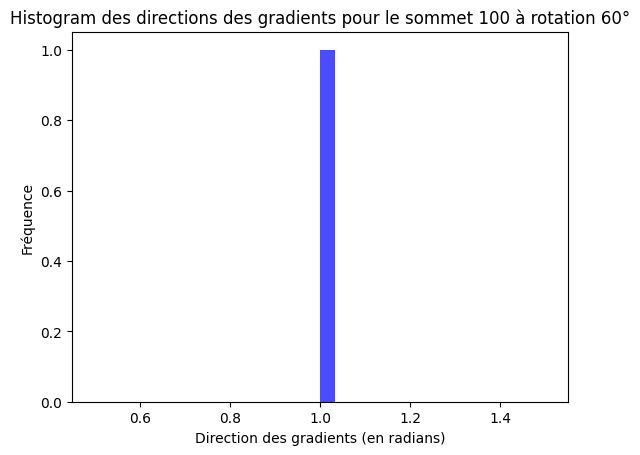

Descripteurs pour l'angle 75 ont la forme: ()


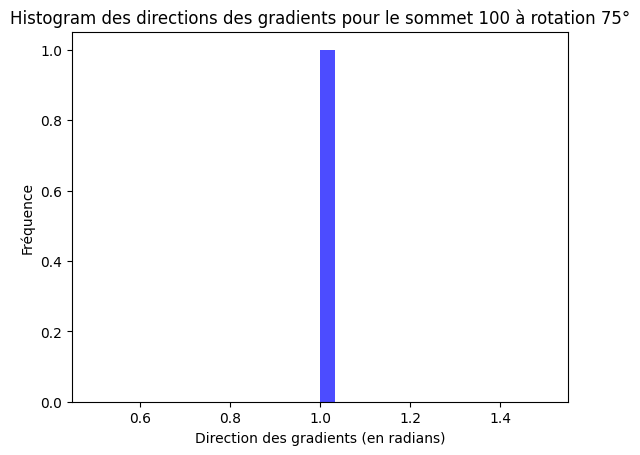

Descripteurs pour l'angle 90 ont la forme: ()


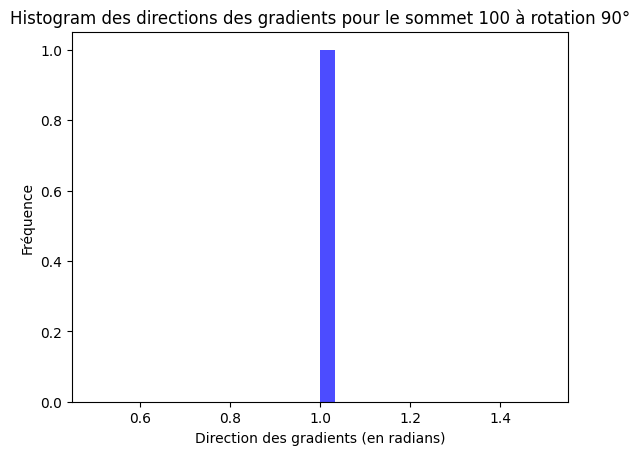

In [94]:
def plot_1d_histogram(descriptor, angle, vertex_index):
    """
    Plot a simple 1D histogram of gradient directions for a given vertex.

    Parameters:
        descriptor (np.ndarray): Gradient descriptor for the vertex.
        angle (float): Rotation angle.
        vertex_index (int): Index of the vertex.
    """
    # Histogram of gradient directions
    fig, ax = plt.subplots()
    ax.hist(descriptor, bins=30, color='blue', alpha=0.7)

    # Labeling
    ax.set_title(f"Histogram des directions des gradients pour le sommet {vertex_index} à rotation {angle}°")
    ax.set_xlabel("Direction des gradients (en radians)")
    ax.set_ylabel("Fréquence")

    plt.show()

# Example usage
sample_vertex_index = 100
for angle, face_descriptors in zip(angles, cosine_similarities):
    print(f"Descripteurs pour l'angle {angle} ont la forme: {descriptors[sample_vertex_index].shape}")
    plot_1d_histogram(descriptors[sample_vertex_index], angle, sample_vertex_index)


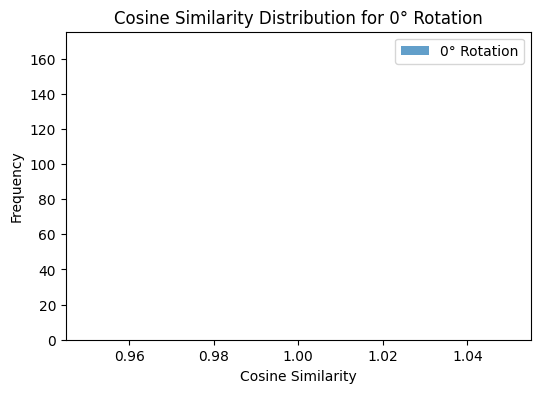

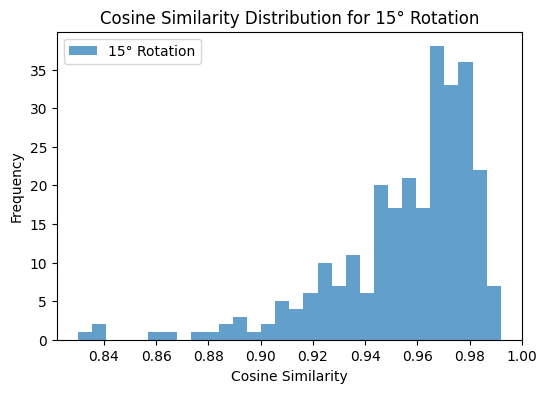

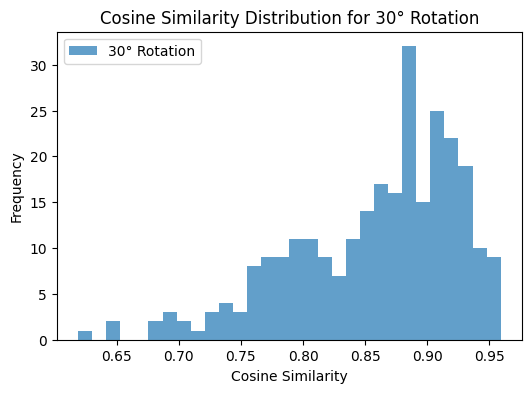

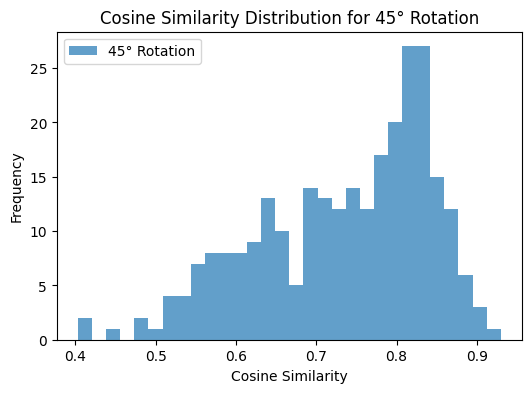

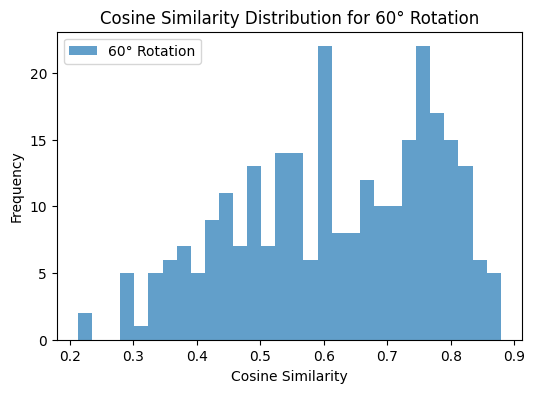

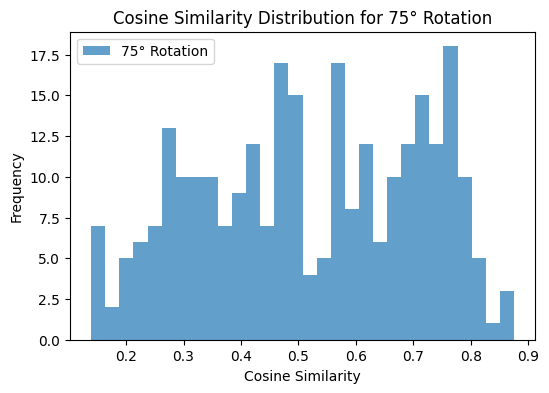

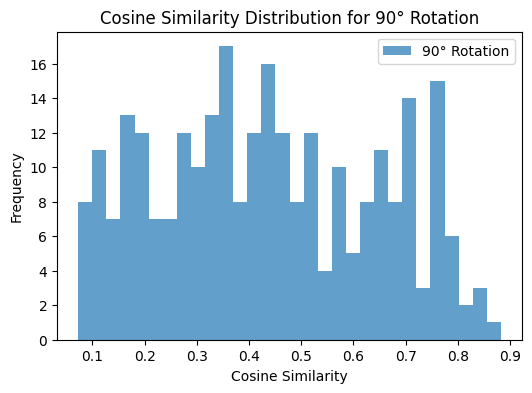

In [95]:
import matplotlib.pyplot as plt

# Plotting the cosine similarities for each angle
for idx, angle in enumerate(angles):
    plt.figure(figsize=(6, 4))
    plt.hist(cosine_similarities[idx], bins=30, alpha=0.7, label=f'{angle}° Rotation')
    plt.title(f'Cosine Similarity Distribution for {angle}° Rotation')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


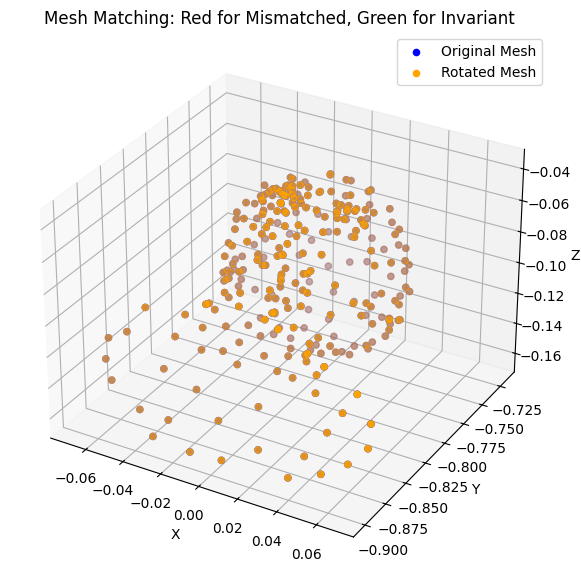

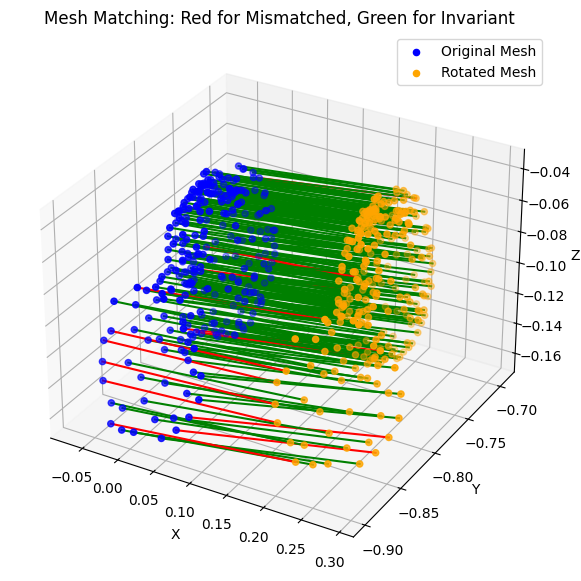

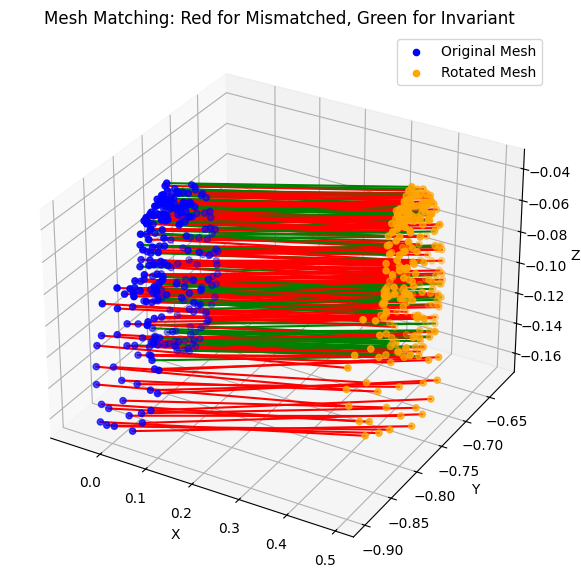

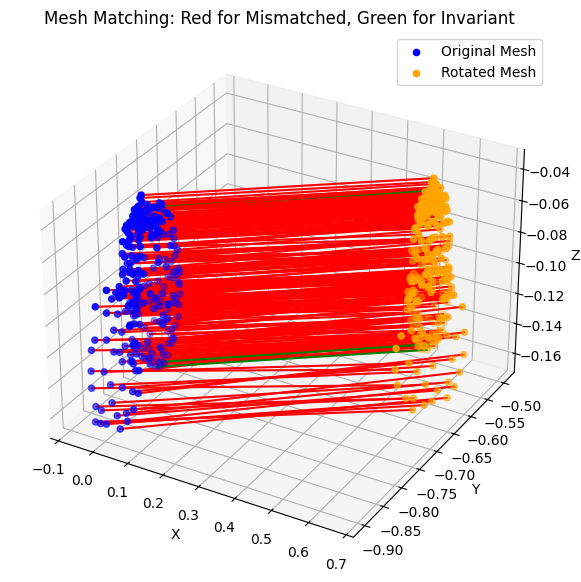

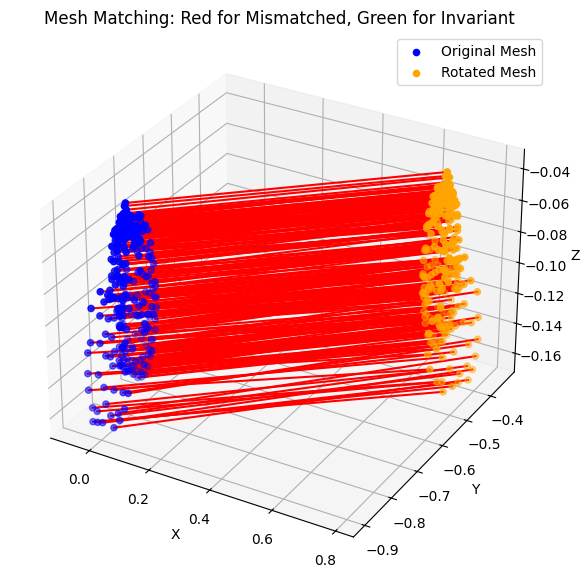

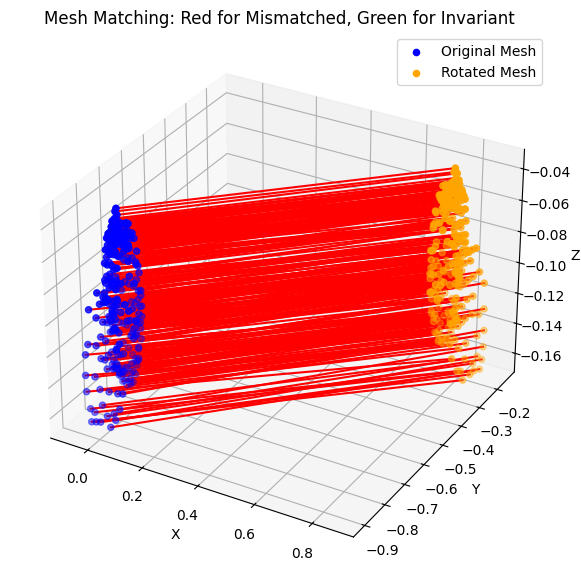

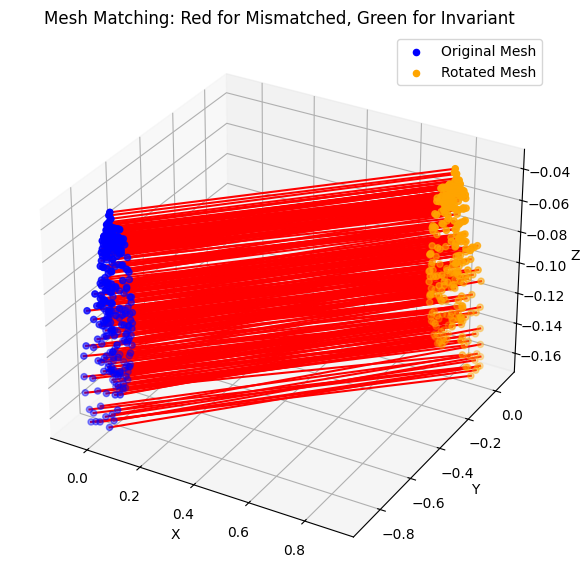

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def compare_descriptors(baseline_descriptors, rotated_descriptors):
    """
    Compare descriptors between baseline and rotated using cosine similarity
    and Euclidean distance.
    """
    # Ensure both descriptors are 2D arrays (num_vertices, descriptor_dim)
    baseline_descriptors = np.atleast_2d(baseline_descriptors)
    rotated_descriptors = np.atleast_2d(rotated_descriptors)

    # Calculate cosine similarity
    dot_product = np.sum(baseline_descriptors * rotated_descriptors, axis=1)
    baseline_norm = np.linalg.norm(baseline_descriptors, axis=1)
    rotated_norm = np.linalg.norm(rotated_descriptors, axis=1)
    cosine_similarity = dot_product / (baseline_norm * rotated_norm + 1e-10)  # Avoid division by zero

    # Calculate Euclidean distance
    euclidean_distance = np.linalg.norm(baseline_descriptors - rotated_descriptors, axis=1)

    return cosine_similarity, euclidean_distance

def plot_matching_meshes(original_vertices, rotated_vertices, cosine_similarities, threshold=0.9):
    """
    Visualize the matching between original and rotated meshes.
    Red lines represent mismatched vertices, green lines represent invariant ones.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(original_vertices)):
        # Compare the cosine similarity for each vertex
        similarity = cosine_similarities[i]

        # Define color based on the similarity threshold
        color = 'green' if similarity >= threshold else 'red'

        # Plot a line between the original and rotated vertices if the similarity is below the threshold
        ax.plot([original_vertices[i, 0], rotated_vertices[i, 0]],
                [original_vertices[i, 1], rotated_vertices[i, 1]],
                [original_vertices[i, 2], rotated_vertices[i, 2]], color=color)

    # Plotting the original and rotated vertices
    ax.scatter(original_vertices[:, 0], original_vertices[:, 1], original_vertices[:, 2], color='blue', label='Original Mesh')
    ax.scatter(rotated_vertices[:, 0], rotated_vertices[:, 1], rotated_vertices[:, 2], color='orange', label='Rotated Mesh')

    ax.set_title("Mesh Matching: Red for Mismatched, Green for Invariant")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

# Example of how to use the function
angles = np.arange(0, 91, 15)  # Rotation from 0° to 90° in increments of 15°

baseline_descriptors = calculate_hog_descriptors(decimated_vertices, decimated_faces)  # Original descriptors

cosine_similarities = []
euclidean_distances = []

for angle in angles:
    rotated_vertices = rotate_mesh(decimated_vertices, angle, axis='z')
    rotated_descriptors = calculate_hog_descriptors(rotated_vertices, decimated_faces)

    # Calculate cosine similarity and Euclidean distance for each vertex
    cosine_sim = np.array([compare_descriptors(baseline_descriptors[i:i+1], rotated_descriptors[i:i+1])[0][0] for i in range(len(baseline_descriptors))])

    # Visualize the matching
    plot_matching_meshes(decimated_vertices, rotated_vertices, cosine_sim)


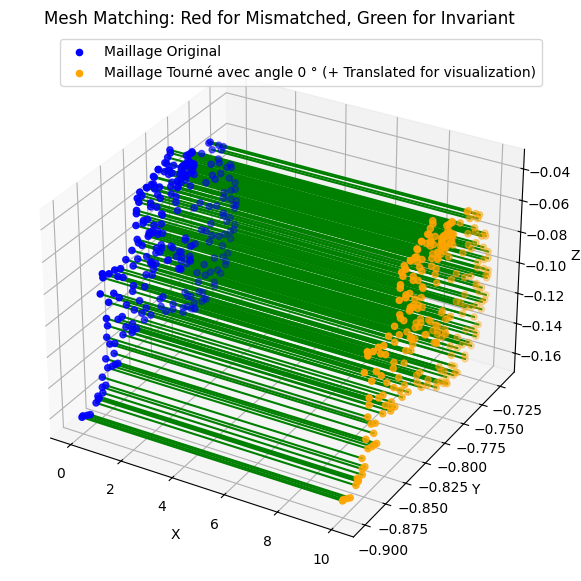

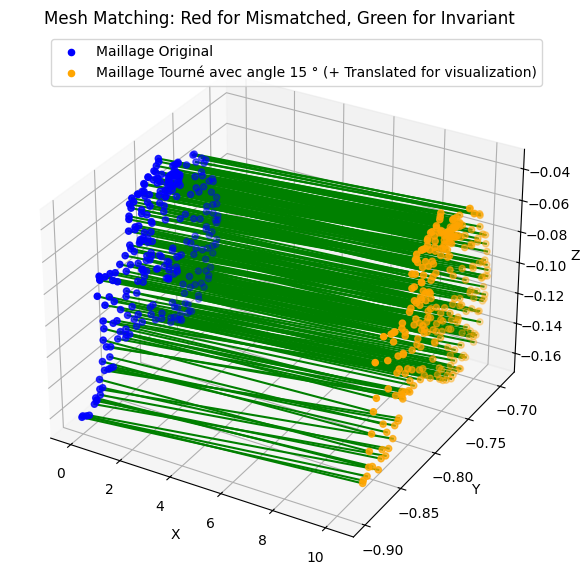

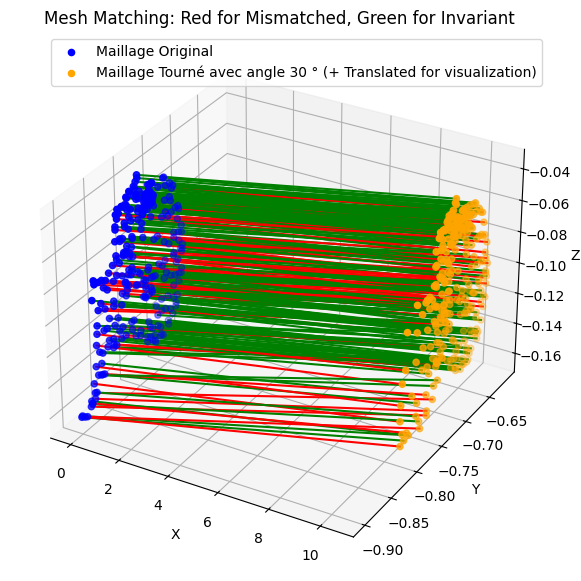

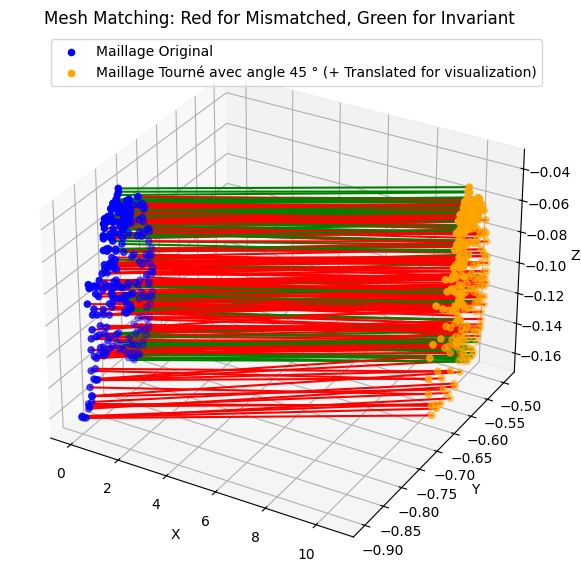

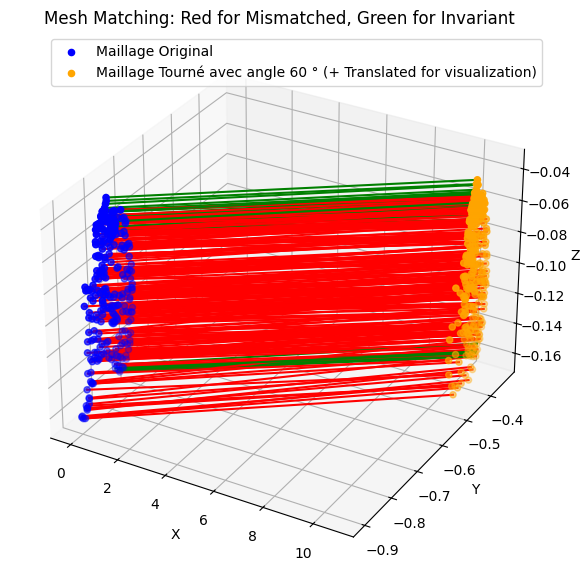

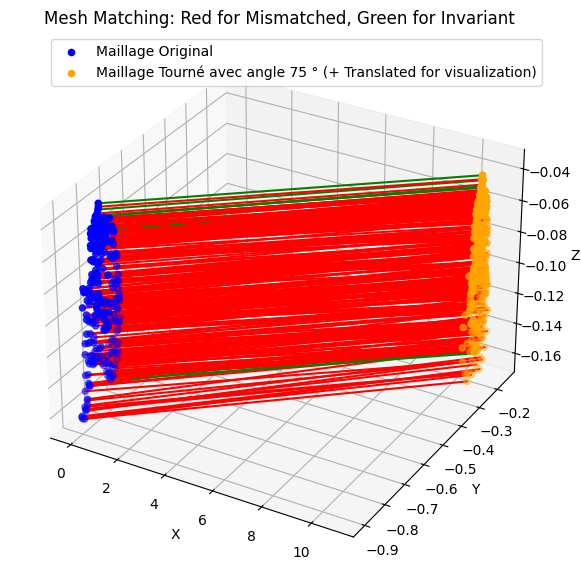

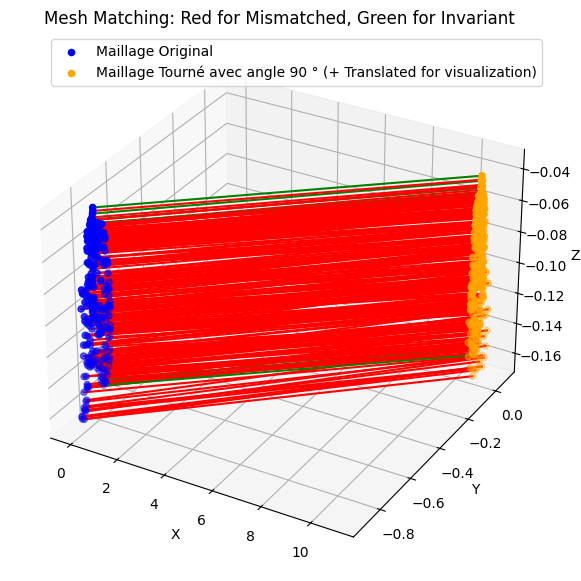

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_matching_meshes(original_vertices, rotated_vertices, cosine_similarities, angle, threshold=0.8, translation=(10, 0, 0)):
    """
    Visualiser l'appariement entre les maillages original et tourné.
    Les lignes rouges représentent les sommets qui ne correspondent pas (dissimilarité),
    tandis que les lignes vertes indiquent ceux qui sont invariants.

    Paramètres:
        original_vertices (np.array): Les sommets du maillage original.
        rotated_vertices (np.array): Les sommets du maillage tourné.
        cosine_similarities (np.array): Valeurs de similarité cosinus pour chaque paire de sommets.
        threshold (float): Le seuil pour déterminer la qualité de l'appariement.
        translation (tuple): Translation à appliquer au maillage tourné pour une meilleure séparation visuelle.
    """
    # Appliquer la translation aux sommets tournés pour une séparation visuelle
    translated_rotated_vertices = rotated_vertices + np.array(translation)

    # Créer une figure 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Boucle pour tracer les lignes entre chaque sommet original et tourné
    for i in range(len(original_vertices)):
        similarity = cosine_similarities[i]  # Récupérer la similarité cosinus pour le sommet i

        # Déterminer la couleur de la ligne selon le seuil
        color = 'green' if similarity >= threshold else 'red'

        # Tracer une ligne entre les sommets originaux et tournés (traduit) pour chaque point
        ax.plot([original_vertices[i, 0], translated_rotated_vertices[i, 0]],
                [original_vertices[i, 1], translated_rotated_vertices[i, 1]],
                [original_vertices[i, 2], translated_rotated_vertices[i, 2]], color=color)

    # Tracer les points du maillage original en bleu et du maillage tourné (traduit) en orange
    ax.scatter(original_vertices[:, 0], original_vertices[:, 1], original_vertices[:, 2], color='blue', label='Maillage Original')
    ax.scatter(translated_rotated_vertices[:, 0], translated_rotated_vertices[:, 1], translated_rotated_vertices[:, 2], color='orange', label=f'Maillage Tourné avec angle {angle} ° (+ Translated for visualization)')

    ax.set_title("Mesh Matching: Red for Mismatched, Green for Invariant")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

# Example of how to use the function
# Calculate cosine similarities as before, and apply translation
for angle in angles:
    # Create a copy of the original mesh vertices to apply rotation, preserving the original data
    rotated_vertices = rotate_mesh(decimated_vertices.copy(), angle, axis='z')

    # Calculate HOG descriptors for the rotated mesh
    rotated_descriptors = calculate_hog_descriptors(rotated_vertices, decimated_faces)

    # Compute cosine similarity for each descriptor pair
    cosine_sim = np.array([compare_descriptors(baseline_descriptors[i], rotated_descriptors[i])[0] for i in range(len(baseline_descriptors))])

    # Visualize mesh matching with the translated rotated mesh
    plot_matching_meshes(decimated_vertices, rotated_vertices, cosine_sim, angle, translation=(10, 0, 0))




---

# **Besoin d'utiliser d'autre méthode: la géodésie**

---



In [98]:
# print(f"sample vertex descriptor: {descriptors[sample_vertex_index]}")

# print(f"Shape of descriptors: {np.array(descriptors).shape}")

In [99]:
import numpy as np
import plotly.graph_objects as go
import open3d as o3d

# Load the mesh (replace with your path)
mesh_simplifiee = o3d.io.read_triangle_mesh("BustBaseMesh_Decimated.obj")
mesh_simplifiee.compute_vertex_normals()
vertices = np.asarray(mesh_simplifiee.vertices)
triangles = np.asarray(mesh_simplifiee.triangles)

# Use only the first 500 vertices for the interactive plot
num_vertices_to_use = 500
vertices = vertices[:num_vertices_to_use]

# Filter triangles to ensure they reference the first 500 vertices
valid_triangle_indices = np.all(triangles < num_vertices_to_use, axis=1)
triangles = triangles[valid_triangle_indices]

# Create a 3D mesh plot with both the mesh and the vertices
fig = go.Figure()

# Add the mesh surface
fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=triangles[:, 0],
    j=triangles[:, 1],
    k=triangles[:, 2],
    opacity=0.5,
    color='lightblue',
    name='Mesh Surface'
))

# Add the vertices as markers with indices
fig.add_trace(go.Scatter3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    mode='markers+text',
    marker=dict(size=5, color='red', opacity=0.8),
    text=[f'Index: {i}' for i in range(len(vertices))],
    hoverinfo='text'
))

# Update layout for better viewing
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
        camera=dict(eye=dict(x=0, y=-1, z=0.5))
    ),
    title='Interactive 3D View of Human Head Mesh with Indexed Points'
)

# Show the figure
fig.show()


In [100]:
# Fonction pour calculer la SRVF d’une courbe (suite de points de la mesh)
def calcul_srvf(curve_points):
    # Calcul des différences entre les points consécutifs
    diffs = np.diff(curve_points, axis=0)
    # Calcul des normes des vecteurs de vitesse
    norms = np.linalg.norm(diffs, axis=1)
    # Normalisation pour obtenir la SRVF
    srvf = diffs / np.sqrt(norms[:, None] + 1e-8)
    return srvf

# Exemple d’utilisation : calcul de la SRVF pour une courbe sur la mesh simplifiée
# Supposons que `points_courbe` représente une suite de points de la mesh
points_courbe = np.asarray(mesh_simplifiee.vertices)[:500]  # On prend une sous-séquence comme exemple
srvf_points = calcul_srvf(points_courbe)

# Affichage de la SRVF pour vérification
print("SRVF calculée pour les points de courbe:", srvf_points)


SRVF calculée pour les points de courbe: [[-2.45263850e-02  3.82454815e-02  7.45542256e-04]
 [-6.39481397e-03 -4.21137422e-02  5.05552839e-03]
 [-6.20052728e-03 -1.73931550e-01  2.82737477e-02]
 ...
 [-2.27454056e-02 -2.94935610e-02 -3.58295394e-03]
 [ 1.57214709e-04  3.13205479e-02  1.31443999e-02]
 [ 1.52619874e-02 -1.70884728e-01 -7.34358446e-03]]
